In [1]:
from lmfit import Parameters
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
from core.util.units import compute_dft
dir()

['BuiltinTrap', 'CachingCompiler', 'DisplayHook', 'DisplayTrap', 'EventManager', 'ExecutionResult', 'InputRejected', 'InterpolatedUnivariateSpline', 'N14_testing', 'N14_testing2', 'N15_testing', 'N15_testing2', 'Parameters', 'QZMQHeartbeat', 'QZMQKernel', 'QZMQStream', 'QtCore', 'RedirectedStdErr', 'RedirectedStdOut', 'StringIO', 'ZMQError', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'ast', 'available_events', 'builtins', 'butter', 'check_linecache_ipython', 'compute_dft', 'config', 'cursor_pos_to_lc', 'datetime', 'double_lorentzdip_testing', 'double_lorentzdip_testing2', 'double_lorentzian_fixedsplitting_testing', 'double_lorentzpeak_testing2', 'encode_images', 'encodebytes', 'errno', 'filters', 'filtfilt', 'fitlogic', 'freqz', 'gaussian', 'gaussiandip_testing2', 'gaussianlinearoffset_testing', 'gaussianlinearoffset_testing2', 'gaussianpeak_testing', 'gaussianpeak_testing2', 'getfigs', 'hashlib', 'hmac', 'jedi', 'json', 'k

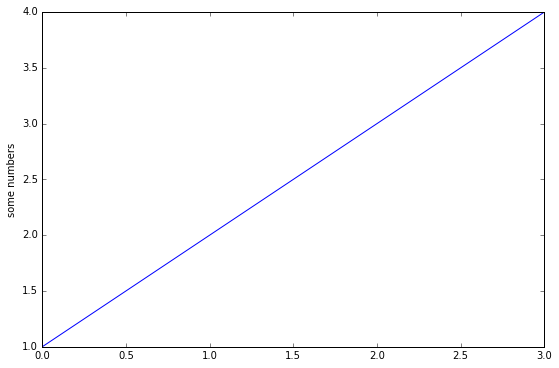

In [2]:
plt.plot([1,2,3,4])
plt.ylabel('some numbers')
plt.show()

In [3]:
fitlogic.fit_list['1d'].keys()

odict_keys(['decayexponential', 'decayexponentialstretched', 'gaussian', 'gaussiandouble', 'gaussianlinearoffset', 'hyperbolicsaturation', 'linear', 'lorentzian', 'lorentziandouble', 'lorentziantriple', 'poissonian', 'poissoniandouble', 'sine', 'sinedouble', 'sinedoublewithexpdecay', 'sinedoublewithtwoexpdecay', 'sineexponentialdecay', 'sinestretchedexponentialdecay', 'sinetriple', 'sinetriplewithexpdecay', 'sinetriplewiththreeexpdecay'])

In [4]:
def N15_testing():
    """ Test function to implement the estimator for the N15 fit with offset. """
    x_axis = np.linspace(2850, 2860, 101)*1e6

    mod,params = fitlogic.make_multiplelorentzian_model(no_of_functions=2)
#            print('Parameters of the model',mod.param_names)

    p = Parameters()

    p.add('l0_amplitude',value=-1e4)
    p.add('l0_center',value=2850*1e6+abs(np.random.random(1)*8)*1e6)
#            p.add('lorentz0_sigma',value=abs(np.random.random(1)*1)*1e6+0.5*1e6)
    p.add('l0_sigma',value=0.5*1e6)
    p.add('l1_amplitude',value=p['l0_amplitude'].value)
    p.add('l1_center',value=p['l0_center'].value+3.03*1e6)
    p.add('l1_sigma',value=p['l0_sigma'].value)
    p.add('offset',value=100000.)

    data_nice = mod.eval(x=x_axis, params=p)

    data_noisy= data_nice + 6000*np.random.normal(size=x_axis.shape)

    data_smooth_lorentz, offset = fitlogic.find_offset_parameter(x_axis, data_noisy)

    print('offset:', offset)

    x_offset = np.array([offset]*len(x_axis))

    plt.figure()
    plt.plot(x_axis, data_noisy, label='noisy data')
    plt.plot(x_axis, data_smooth_lorentz, label='smoothed data')
    plt.plot(x_axis, x_offset, label='offset estimation')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    hf_splitting = 3.03 * 1e6 # Hz

    # filter should always have a length of approx linewidth 1MHz
    points_within_1MHz = len(x_axis) / (x_axis.max() - x_axis.min()) * 1e6

    # filter should have a width of 4 MHz
    x_filter = np.linspace(0, 4 * points_within_1MHz, 4 * points_within_1MHz)
    lorentz = np.piecewise(
        x_filter,
        [(x_filter >= 0)*(x_filter < len(x_filter)/4),
            (x_filter >= len(x_filter)/4)*(x_filter < len(x_filter)*3/4),
            (x_filter >= len(x_filter)*3/4)],
        [1, 0, 1])

    # if the filter is smaller than 3 points a convolution does not make sense
    if len(lorentz) >= 3:
        data_convolved = filters.convolve1d(
            data_smooth_lorentz,
            lorentz / lorentz.sum(),
            mode='constant',
            cval=data_smooth_lorentz.max())
        x_axis_min = x_axis[data_convolved.argmin()]-hf_splitting/2.
    else:
        x_axis_min = x_axis[data_smooth_lorentz.argmin()]

    # data_level = data_smooth_lorentz - data_smooth_lorentz.max()
    data_level = data_smooth_lorentz - offset

    # multiply
    minimum_level = data_level.min()

    x_min_level = np.array([minimum_level] * len(x_axis))

    plt.figure()
    plt.plot(x_axis, data_noisy-offset, label='leveled noisy data')
    plt.plot(x_axis, data_level, label='leveled smoothed data')
    plt.plot(x_axis, x_min_level, label='minimum level estimation')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    # integral of data:
    function = InterpolatedUnivariateSpline(x_axis, data_level, k=1)
    Integral = function.integral(x_axis[0], x_axis[-1])

    # assume both peaks contribute to the linewidth, so devive by 2:
    sigma = abs(Integral /(np.pi * minimum_level) )/2

    # amplitude = -1*abs(minimum_level*np.pi*sigma)
    amplitude = -abs(minimum_level)

    minimal_sigma = x_axis[1]-x_axis[0]
    maximal_sigma = x_axis[-1]-x_axis[0]

    mod, params = fitlogic.make_multiplelorentzian_model(no_of_functions=2)

    params['l0_amplitude'].set(value=amplitude, max=-1e-6)
    params['l0_center'].set(value=x_axis_min)
    params['l0_sigma'].set(value=sigma, min=minimal_sigma,
                                 max=maximal_sigma)
    params['l1_amplitude'].set(value=params['l0_amplitude'].value,
                               max=-1e-6)
    params['l1_center'].set(value=params['l0_center'].value+hf_splitting,
                            expr='l0_center+3.03*1e6')
    params['l1_sigma'].set(value=params['l0_sigma'].value,
                           min=minimal_sigma, max=maximal_sigma,
                           expr='l0_sigma')
    params['offset'].set(value=offset)

    result = mod.fit(data_noisy, x=x_axis, params=params)

    plt.figure()
    plt.plot(x_axis, data_noisy, label='original data')
    plt.plot(x_axis, result.init_fit,'-y', label='initial values')
    plt.plot(x_axis, result.best_fit,'-r', label='actual fit')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

In [5]:
def N15_testing2():
    """ Test direkt the implemented fit method with simulated data."""

    x_axis = np.linspace(2850, 2860, 101)*1e6

    mod, params = fitlogic.make_multiplelorentzian_model(no_of_functions=2)
#            print('Parameters of the model',mod.param_names)

    p = Parameters()

    p.add('l0_amplitude', value=-3e4)
    p.add('l0_center', value=2850*1e6+abs(np.random.random(1)*8)*1e6)
#            p.add('lorentz0_sigma',value=abs(np.random.random(1)*1)*1e6+0.5*1e6)
    p.add('l0_sigma', value=0.5*1e6)
    p.add('l1_amplitude', value=p['l0_amplitude'].value)
    p.add('l1_center', value=p['l0_center'].value+3.03*1e6)
    p.add('l1_sigma', value=p['l0_sigma'].value)
    p.add('offset', value=100.)

    data_nice = mod.eval(x=x_axis, params=p)

    data_noisy = (data_nice + 14000 * np.random.normal(size=x_axis.shape))

    result = fitlogic.make_lorentziandouble_fit(x_axis, data_noisy, estimator=fitlogic.estimate_lorentziandouble_N15)

    #plt.figure()
    plt.plot(x_axis, data_noisy,'-b', label='data')
    plt.plot(x_axis, result.init_fit,'-y', label='initial values')
    plt.plot(x_axis, result.best_fit,'-r', label='actual fit')
    plt.plot(x_axis, data_nice,'-g', label='actual fit')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

In [6]:
def N14_testing():
    """ Test function to implement the estimator for the N14 fit with offset. """

    # get the model of the three lorentzian peak, this gives you the
    # ability to get the used parameter container for the fit.
    mod, params = fitlogic.make_multiplelorentzian_model(no_of_functions=3)

    x_axis = np.linspace(2720, 2890, 301)*1e6


    sigma = 1e6  # linewidth

    amplitude = -1e4

    minimal_linewidth = (x_axis[1]-x_axis[0])/4
    maximal_linewidth = x_axis[-1]-x_axis[0]
    peak_pos1 = 2852*1e6
    offset = 150000

    params['l0_amplitude'].set(value=amplitude)
    params['l0_center'].set(value=peak_pos1)
    params['l0_sigma'].set(value=sigma)
    params['l1_amplitude'].set(value=amplitude)
    params['l1_center'].set(value=params['l0_center'].value+2.15*1e6)
    params['l1_sigma'].set(value=sigma)
    params['l2_amplitude'].set(value=amplitude)
    params['l2_center'].set(value=params['l1_center'].value+2.15*1e6)
    params['l2_sigma'].set(value=sigma)
    params['offset'].set(value=offset)

    data_noisy = mod.eval(x=x_axis, params=params) + 7000 * np.random.normal(size=x_axis.shape)

    data_smooth_lorentz, offset = fitlogic.find_offset_parameter(x_axis, data_noisy)

    print('offset', offset)

    # level of the data, that means the offset is subtracted and the real data
    # are present
    data_level = data_smooth_lorentz - offset
    minimum_level = data_level.min() * 1.5

    print('minimum level = amplitude:', minimum_level)
    offset_data = np.array([offset]*len(x_axis))

    plt.figure()
    plt.plot(x_axis, data_noisy,'-b', label='data')
    plt.plot(x_axis, data_smooth_lorentz,'-g',linewidth=2.0, label='smoothed data')
    plt.plot(x_axis, offset_data,linewidth=2.0, label='estimated offset')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    plt.figure()
    plt.plot(x_axis, data_level,'-b', label='leveled data')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    # Create now a filter of length 5MHz, then create a step-wise function with
    # three dips. This step-wise function will be convolved with the smoothed
    # data, where the maximal contribution will be if the peaks are within the
    # filter. Take that to obtain from that the accurate peak position:

    # filter of one dip should always have a length of approx linewidth 1MHz
    points_within_1MHz = len(x_axis)/(x_axis.max()-x_axis.min()) * 1e6

    # filter should have a width of 5MHz
    x_filter = np.linspace(0, 5*points_within_1MHz, 5*points_within_1MHz)
    lorentz = np.piecewise(x_filter, [(x_filter >= 0)                   * (x_filter < len(x_filter)*1/5),
                                      (x_filter >= len(x_filter)*1/5)   * (x_filter < len(x_filter)*2/5),
                                      (x_filter >= len(x_filter)*2/5)   * (x_filter < len(x_filter)*3/5),
                                      (x_filter >= len(x_filter)*3/5)   * (x_filter < len(x_filter)*4/5),
                                      (x_filter >= len(x_filter)*4/5)],
                           [1, 0, 1, 0, 1])

    # if the filter is smaller than 5 points a convolution does not make sense
    if len(lorentz) >= 5:
        data_convolved = filters.convolve1d(data_smooth_lorentz,
                                            lorentz/lorentz.sum(),
                                            mode='constant',
                                            cval=data_smooth_lorentz.max())
        x_axis_min = x_axis[data_convolved.argmin()]-2.15*1e6
    else:
        x_axis_min = x_axis[data_smooth_lorentz.argmin()]-2.15*1e6

    plt.figure()
    plt.plot(x_axis, data_convolved,'-b', label='Convoluted result')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    # In order to perform a smooth integral to obtain the area under the curve
    # make an interpolation of the passed data, in case they are very sparse.
    # That increases the accuracy of the calculated Integral.
    # integral of data corresponds to sqrt(2) * Amplitude * Sigma

    smoothing_spline = 1    # must be 1<= smoothing_spline <= 5
    function = InterpolatedUnivariateSpline(x_axis, data_level, k=smoothing_spline)
    integrated_area = function.integral(x_axis[0], x_axis[-1])

    # sigma = abs(integrated_area / (minimum_level/np.pi))
    # That is wrong, so commenting out:
    sigma = abs(integrated_area /(np.pi * minimum_level))/1.5

    amplitude = -1*abs(minimum_level)

    # Since the total amplitude of the lorentzian is depending on sigma it makes
    # sense to vary sigma within an interval, which is smaller than the minimal
    # distance between two points. Then the fit algorithm will have a larger
    # range to determine the amplitude properly. That is the main issue with the
    # fit!
    minimal_linewidth = (x_axis[1]-x_axis[0])/4
    maximal_linewidth = x_axis[-1]-x_axis[0]

    # The linewidth of all the lorentzians are set to be the same! that is a
    # physical constraint for the N14 fitting.

    # Fill the parameter container, with the estimated values, which should be
    # passed to the fit algorithm:
    params['l0_amplitude'].set(value=amplitude, max=-1e-6)
    params['l0_center'].set(value=x_axis_min)
    params['l0_sigma'].set(value=sigma, min=minimal_linewidth,
                                 max=maximal_linewidth)
    params['l1_amplitude'].set(value=amplitude, max=-1e-6)
    params['l1_center'].set(value=x_axis_min+2.15*1e6,
                                  expr='l0_center+2.15*1e6')
    params['l1_sigma'].set(value=sigma, min=minimal_linewidth,
                                 max=maximal_linewidth, expr='l0_sigma')
    params['l2_amplitude'].set(value=amplitude, max=-1e-6)
    params['l2_center'].set(value=x_axis_min+2.15*1e6,
                                  expr='l0_center+4.3*1e6')
    params['l2_sigma'].set(value=sigma, min=minimal_linewidth,
                                 max=maximal_linewidth, expr='l0_sigma')
    params['offset'].set(value=offset)


    result = mod.fit(data_noisy, x=x_axis, params=params)

    result.params['offset'].unit = 'Hz'


    plt.figure()
    plt.plot(x_axis, data_noisy,'-b', label='data')
    plt.plot(x_axis, result.best_fit,'-r', label='best fit result')
    plt.plot(x_axis, result.init_fit,'-g',label='initial fit')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
    plt.show()
    return result

In [7]:
def N14_testing2():
    """ Test direkt the implemented fit method with simulated data."""

    # get the model of the three lorentzian peak, this gives you the
    # ability to get the used parameter container for the fit.
    mod, params = fitlogic.make_multiplelorentzian_model(no_of_functions=3)

    x_axis = np.linspace(2845, 2860, 101)*1e6

    sigma = 1e6  # linewidth

    amplitude = -3e4

    minimal_linewidth = (x_axis[1]-x_axis[0])/4
    maximal_linewidth = x_axis[-1]-x_axis[0]
    peak_pos1 = 2852*1e6
    offset = 150000

    params['l0_amplitude'].set(value=amplitude)
    params['l0_center'].set(value=peak_pos1)
    params['l0_sigma'].set(value=sigma)
    params['l1_amplitude'].set(value=amplitude)
    params['l1_center'].set(value=params['l0_center'].value+2.15*1e6)
    params['l1_sigma'].set(value=sigma)
    params['l2_amplitude'].set(value=amplitude)
    params['l2_center'].set(value=params['l1_center'].value+2.15*1e6)
    params['l2_sigma'].set(value=sigma)
    params['offset'].set(value=offset)

    data_noisy=(mod.eval(x=x_axis, params=params) + 5000*np.random.normal(size=x_axis.shape))

    result = fitlogic.make_lorentziantriple_fit(x_axis, data_noisy, estimator=fitlogic.estimate_lorentziantriple_N14)

    print(result.fit_report())

    plt.figure()
    plt.plot(x_axis, data_noisy,'-b', label='data')
    plt.plot(x_axis, result.best_fit,'-r', label='best fit result')
    plt.plot(x_axis, result.init_fit,'-g',label='initial fit')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
    plt.show()


In [8]:
def gaussianpeak_testing():
    """ Test the Gaussian peak or dip estimator. """

    x_axis = np.linspace(0, 5, 50)

    ampl = 10000
    center = 3
    sigma = 1
    offset = 10000

    mod_final, params = fitlogic.make_gaussian_model()
    data_noisy = mod_final.eval(
        x=x_axis,
        amplitude=ampl,
        center=center,
        sigma=sigma,
        offset=offset) + 4000*abs(np.random.normal(size=x_axis.shape))

    stepsize = abs(x_axis[1] - x_axis[0])
    n_steps = len(x_axis)


    # Smooth the provided data, so that noise fluctuations will
    # not disturb the parameter estimation.
    std_dev = 2
    data_smoothed = filters.gaussian_filter1d(data_noisy, std_dev)

    plt.figure()
    plt.plot(x_axis, data_noisy, label='data')
    plt.plot(x_axis, data_smoothed, label='smoothed data')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    # Define constraints
    # maximal and minimal the length of the given array to the right and to the
    # left:
    center_min = (x_axis[0]) - n_steps * stepsize
    center_max = (x_axis[-1]) + n_steps * stepsize
    ampl_min = 0
    sigma_min = stepsize
    sigma_max = 3 * (x_axis[-1] - x_axis[0])

    # set parameters
    offset = data_smoothed.min()
    params['offset'].set(value=offset)

    # it is more reliable to obtain select the maximal value rather then
    # calculating the first moment of the gaussian distribution (which is the
    # mean value), since it is unreliable if the distribution begins or ends at
    # the edges of the data:
    mean_val_calc =  np.sum(x_axis*(data_smoothed)) / np.sum(data_smoothed)
    center_val = x_axis[np.argmax(data_smoothed)]
    params['center'].set(value=center_val, min=center_min, max=center_max)

    # calculate the second moment of the gaussian distribution: int (x^2 * f(x) dx)
    mom2 = np.sum((x_axis)**2 * (data_smoothed)) / np.sum(data_smoothed)

    # and use the standard formula to obtain the standard deviation:
    #   sigma^2 = int( (x-mean)^2 f(x) dx ) = int (x^2 * f(x) dx) - mean^2

    print("mom2", mom2)
    print("std: ", np.sqrt(abs(mom2 - mean_val_calc**2)))

    # if the mean is situated at the edges of the distribution then this
    # procedure performs better then setting the initial value for sigma to
    # 1/3 of the length of the distibution since the calculated value for the
    # mean is then higher, which will decrease eventually the initial value for
    # sigma. But if the peak values is within the distribution the standard
    # deviation formula performs even better:
    params['sigma'].set(value=np.sqrt(abs(mom2 - mean_val_calc**2)), min=sigma_min, max=sigma_max)

    # do not set the maximal amplitude value based on the distribution, since
    # the fit will fail if the peak is at the edges or beyond the range of the
    # x values.
    params['amplitude'].set(value=data_smoothed.max() - data_smoothed.min(), min=ampl_min)

    result = mod_final.fit(data_noisy, x=x_axis, params=params)

    plt.figure()
    plt.plot(x_axis, data_noisy,'-b', label='data')
    plt.plot(x_axis,result.best_fit,'-r', label='best fit result')
    plt.plot(x_axis,result.init_fit,'-g',label='initial fit')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()
    print(result.fit_report())

In [9]:
def gaussianpeak_testing2():
    """ Test the implemented Gaussian peak fit. """

    x_axis = np.linspace(0, 5, 11)

    ampl = 10000
    center = 3
    sigma = 1
    offset = 10000

    mod_final, params = fitlogic.make_gaussian_model()
    data_noisy = mod_final.eval(
        x=x_axis,
        amplitude=ampl,
        center=center,
        sigma=sigma,
        offset=offset) + 2000*abs(np.random.normal(size=x_axis.shape))

    result = fitlogic.make_gaussian_fit(x_axis=x_axis, data=data_noisy, estimator=fitlogic.estimate_gaussian_peak)

    plt.figure()
    plt.plot(x_axis, data_noisy,'-b', label='data')
    plt.plot(x_axis, result.best_fit,'-r', label='best fit result')
    plt.plot(x_axis, result.init_fit,'-g',label='initial fit')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()
    print(result.fit_report())

In [10]:
def two_gaussian_peak_testing():
    """ Test the implemented estimator for two gaussian peaks with offset """

    start=100000
    stop= 500000
    num_points=int((stop-start)/2000)
    x_axis = np.linspace(start, stop, num_points)

    mod, params = fitlogic.make_multiplegaussianoffset_model(no_of_functions=2)

    amplitude0 = 75000+np.random.random(1)*50000
    amplitude1 = amplitude0*1.5
#    splitting = 100000  # abs(np.random.random(1)*100000)
    splitting = abs(np.random.random(1)*200000)
    center0 = 160000
#    center1 = 300000
    center1 = center0 + splitting
    sigma0 = 25000+np.random.random(1)*20000
    sigma1 = 25000+np.random.random(1)*20000
    splitting = 100000  # abs(np.random.random(1)*300000)

    params['g0_amplitude'].value = amplitude0
    params['g0_center'].value = center0
    params['g0_sigma'].value = sigma0
    params['g1_amplitude'].value = amplitude1
    params['g1_center'].value = center1
    params['g1_sigma'].value = sigma1
    params['offset'].value = 0


    data_noisy=(mod.eval(x=x_axis,params=params) + 20000*np.random.normal(size=x_axis.shape))

    plt.figure()
    plt.plot(x_axis, data_noisy, label="data")
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    threshold_fraction=0.4
    minimal_threshold=0.2
    sigma_threshold_fraction=0.3

    mod_lor, params_lor = fitlogic.make_multiplelorentzian_model(no_of_functions=2)

    error, params_lor = fitlogic.estimate_lorentziandouble_dip(
        x_axis=x_axis,
        data=-data_noisy,
        params=params_lor,
        threshold_fraction=threshold_fraction,
        minimal_threshold=minimal_threshold,
        sigma_threshold_fraction=sigma_threshold_fraction)

    result_lor = mod_lor.fit(-data_noisy, x=x_axis, params=params_lor)

    plt.figure()
    plt.plot(x_axis, -data_noisy, label="data")
    plt.plot(x_axis, result_lor.init_fit, label='init lorentz fit')
    plt.plot(x_axis, result_lor.best_fit, label='actual lorentz fit')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    mod, params = fitlogic.make_multiplegaussianoffset_model(no_of_functions=2)

    params['g0_amplitude'].value = -params_lor['l0_amplitude'].value
    params['g0_center'].value = params_lor['l0_center'].value
    params['g0_sigma'].value = params_lor['l0_sigma'].value/(np.sqrt(2*np.log(2)))
    params['g1_amplitude'].value = -params_lor['l1_amplitude'].value
    params['g1_center'].value = params_lor['l1_center'].value
    params['g1_sigma'].value = params_lor['l1_sigma'].value/(np.sqrt(2*np.log(2)))
    params['offset'].value = -params_lor['offset'].value

    result = mod.fit(data_noisy, x=x_axis, params=params)

    plt.figure()
    plt.plot(x_axis, data_noisy, label="data")
    plt.plot(x_axis, result.init_fit, label='initial value double gauss')
    plt.plot(x_axis, result.best_fit, label='fit')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    print(result.fit_report())

In [11]:
def two_gaussian_peak_testing2():
    """ Test the implemented Two Gaussian peak with offset fit. """

    start=100000
    stop= 500000
    num_points=int((stop-start)/2000)
    x_axis = np.linspace(start, stop, num_points)

    mod, params = fitlogic.make_multiplegaussianoffset_model(no_of_functions=2)

    amplitude0 = 75000 + np.random.random(1) * 50000
    amplitude1 = amplitude0*1.5
#    splitting = 100000  # abs(np.random.random(1)*100000)
    splitting = abs(np.random.random(1)*200000)
    center0 = 160000
#    center1 = 300000
    center1 = center0 + splitting
    sigma0 = 25000 + np.random.random(1) * 20000
    sigma1 = 25000 + np.random.random(1) * 20000
    splitting = 100000  # abs(np.random.random(1)*300000)

    params['g0_amplitude'].value = amplitude0
    params['g0_center'].value = center0
    params['g0_sigma'].value = sigma0
    params['g1_amplitude'].value = amplitude1
    params['g1_center'].value = center1
    params['g1_sigma'].value = sigma1
    params['offset'].value = 0

    data_noisy = (mod.eval(x=x_axis,params=params) + 20000 * np.random.normal(size=x_axis.shape))

    result = fitlogic.make_gaussiandouble_fit(
        x_axis=x_axis,
        data=data_noisy,
        estimator=fitlogic.estimate_gaussiandouble_peak)

    plt.figure()
    plt.plot(x_axis, data_noisy, label="data")
    plt.plot(x_axis, result.init_fit, label='initial value double gauss')
    plt.plot(x_axis, result.best_fit, label='fit')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    print(result.fit_report())

In [12]:
def two_gaussian_dip_testing2():
    """ Test the implemented Two Gaussian dip with offset fit. """

    start=100000
    stop= 500000
    num_points=int((stop-start)/2000)
    x_axis = np.linspace(start, stop, num_points)

    mod, params = fitlogic.make_multiplegaussianoffset_model(no_of_functions=2)

    amplitude0 = -75000 + np.random.random(1) * 50000
    amplitude1 = amplitude0*1.5
#    splitting = 100000  # abs(np.random.random(1)*100000)
    splitting = abs(np.random.random(1) * 200000)
    center0 = 160000
#    center1 = 300000
    center1 = center0 + splitting
    sigma0 = 2500 + np.random.random(1) * 8000
    sigma1 = 2500 + np.random.random(1) * 8000
    splitting = 100000  # abs(np.random.random(1)*300000)
    offset = 200000

    params['g0_amplitude'].value = amplitude0
    params['g0_center'].value = center0
    params['g0_sigma'].value = sigma0
    params['g1_amplitude'].value = amplitude1
    params['g1_center'].value = center1
    params['g1_sigma'].value = sigma1
    params['offset'].value = offset


    data_noisy=(mod.eval(x=x_axis,params=params) + 30000 * np.random.normal(size=x_axis.shape))

    result = fitlogic.make_gaussiandouble_fit(
        x_axis=x_axis,
        data=data_noisy,
        estimator=fitlogic.estimate_gaussiandouble_dip)

    plt.figure()
    plt.plot(x_axis, data_noisy, label="data")
    plt.plot(x_axis, result.init_fit, label='initial value double gauss')
    plt.plot(x_axis, result.best_fit, label='fit')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0)
    plt.show()

    print(result.fit_report())

In [13]:
def double_lorentzdip_testing():
    """ Test function to implement the estimator for the double lorentz dip
        fit with offset. """

    start = 2800
    stop = 2950
    num_points = int((stop-start)/2)*1
    x_axis = np.linspace(start, stop, num_points)

    x_nice = np.linspace(start, stop, num_points*4)

    mod, params = fitlogic.make_multiplelorentzian_model(no_of_functions=2)

    p=Parameters()

    #============ Create data ==========
    p.add('l0_amplitude',value=-abs(np.random.random(1)*2+20))
    p.add('l0_center',value=np.random.random(1)*150.0+2800)
    p.add('l0_sigma',value=abs(np.random.random(1)*1.+1.))
    p.add('l1_center',value=np.random.random(1)*150.0+2800)
    p.add('l1_sigma',value=abs(np.random.random(1)*4.+1.))
    p.add('l1_amplitude',value=-abs(np.random.random(1)*1+10))

    p.add('offset',value=100.)

    data_noisy = (mod.eval(x=x_axis,params=p) + 6 * np.random.normal(size=x_axis.shape))

    result = fitlogic.make_lorentziandouble_fit(
        x_axis=x_axis,
        data=data_noisy,
        estimator=fitlogic.estimate_lorentziandouble_dip)

    data_smooth, offset = fitlogic.find_offset_parameter(x_axis, data_noisy)

    data_level = data_smooth - offset

    threshold_fraction = 0.3
    minimal_threshold =  0.01
    sigma_threshold_fraction = 0.3

    ret_val = fitlogic._search_double_dip(
        x_axis,
        data_level,
        threshold_fraction,
        minimal_threshold,
        sigma_threshold_fraction)

    error = ret_val[0]
    sigma0_argleft, dip0_arg, sigma0_argright = ret_val[1:4]
    sigma1_argleft, dip1_arg , sigma1_argright = ret_val[4:7]

    if dip0_arg == dip1_arg:
        lorentz0_amplitude = data_level[dip0_arg]/2.
        lorentz1_amplitude = lorentz0_amplitude
    else:
        lorentz0_amplitude = data_level[dip0_arg]
        lorentz1_amplitude = data_level[dip1_arg]

    lorentz0_center = x_axis[dip0_arg]
    lorentz1_center = x_axis[dip1_arg]


    smoothing_spline = 1    # must be 1<= smoothing_spline <= 5
    function = InterpolatedUnivariateSpline(
        x_axis,
        data_level,
        k=smoothing_spline)
    numerical_integral_0 = function.integral(
        x_axis[sigma0_argleft],
        x_axis[sigma0_argright])

    lorentz0_sigma = abs(numerical_integral_0 / (np.pi * lorentz0_amplitude))

    numerical_integral_1 = numerical_integral_0

    lorentz1_sigma = abs(numerical_integral_1 / (np.pi * lorentz1_amplitude))

    stepsize = x_axis[1]-x_axis[0]
    full_width = x_axis[-1]-x_axis[0]
    n_steps = len(x_axis)

    mod, params = fitlogic.make_multiplelorentzian_model(no_of_functions=2)

    if lorentz0_center < lorentz1_center:
        params['l0_amplitude'].set(value=lorentz0_amplitude, max=-0.01)
        params['l0_sigma'].set(value=lorentz0_sigma, min=stepsize/2, max=full_width*4)
        params['l0_center'].set(value=lorentz0_center,
                                min=(x_axis[0])-n_steps*stepsize,
                                max=(x_axis[-1])+n_steps*stepsize)
        params['l1_amplitude'].set(value=lorentz1_amplitude, max=-0.01)
        params['l1_sigma'].set(value=lorentz1_sigma, min=stepsize/2,
                               max=full_width*4)
        params['l1_center'].set(value=lorentz1_center,
                                min=(x_axis[0])-n_steps*stepsize,
                                max=(x_axis[-1])+n_steps*stepsize)
    else:
        params['l0_amplitude'].set(value=lorentz1_amplitude, max=-0.01)
        params['l0_sigma'].set(value=lorentz1_sigma, min=stepsize/2,
                               max=full_width*4)
        params['l0_center'].set(value=lorentz1_center,
                                min=(x_axis[0])-n_steps*stepsize,
                                max=(x_axis[-1])+n_steps*stepsize)
        params['l1_amplitude'].set(value=lorentz0_amplitude, max=-0.01)
        params['l1_sigma'].set(value=lorentz0_sigma, min=stepsize/2,
                               max=full_width*4)
        params['l1_center'].set(value=lorentz0_center,
                                min=(x_axis[0])-n_steps*stepsize,
                                max=(x_axis[-1])+n_steps*stepsize)

    params['offset'].set(value=offset)

    result = mod.fit(data_noisy, x=x_axis, params=params)

    plt.figure()
    plt.plot(x_axis, data_noisy,'o', label='noisy data')
    plt.plot(x_axis, result.init_fit,'-y', label='initial fit')
    plt.plot(x_axis, result.best_fit,'-r', linewidth=2.0, label='actual fit')
    plt.plot(x_axis, data_smooth,'-g', label='smooth data')
    plt.plot(x_nice,mod.eval(x=x_nice,params=result.params),'b',label='original')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

In [14]:
def lorentzianpeak_testing2():
    """ Test the lorentzian fit directy with simulated data. """
    x_axis = np.linspace(800, 1000, 101)

    mod, params = fitlogic.make_lorentzian_model()
    print('Parameters of the model',mod.param_names)
    params = Parameters()

    params.add('amplitude',value=10.)
    params.add('center',value=920.)
    params.add('sigma',value=5)
    params.add('offset', value=10.)

    data_nice = mod.eval(x=x_axis,params=params)
    data_noisy = data_nice + 5.0*np.random.normal(size=x_axis.shape)

    result = fitlogic.make_lorentzian_fit(
        x_axis=x_axis,
        data=data_noisy,
        estimator=fitlogic.estimate_lorentzian_peak)

    plt.figure()
    plt.plot(x_axis, data_nice, label='ideal data')
    plt.plot(x_axis, data_noisy, label='noisy simulated data')
    plt.plot(x_axis, result.best_fit, '-r', label='actual fit')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

In [15]:
def lorentziandip_testing2():
    """ Test the lorentzian fit directy with simulated data. """
    x_axis = np.linspace(800, 1000, 101)

    mod, params = fitlogic.make_lorentzian_model()
    print('Parameters of the model',mod.param_names)
    params = Parameters()

    params.add('amplitude',value=-10.)
    params.add('center',value=920.)
    params.add('sigma',value=5)
    params.add('offset', value=20.)

    data_nice = mod.eval(x=x_axis,params=params)
    data_noisy = data_nice + 2.0*np.random.normal(size=x_axis.shape)
    
    print(fitlogic.estimate_lorentzian_dip)

    result = fitlogic.make_lorentzian_fit(
        x_axis=x_axis,
        data=data_noisy,
        units=["MHz"],
        estimator=fitlogic.estimate_lorentzian_dip)

    plt.figure()
    plt.plot(x_axis, data_nice, label='ideal data')
    plt.plot(x_axis, data_noisy, label='noisy simulated data')
    plt.plot(x_axis, result.best_fit, '-r', label='actual fit')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    print(result.fit_report())
    print(result.result_str_dict)

In [16]:
def lorentziandip_testing():
    """ Test the lorentzian estimator. """
    x_axis = np.linspace(800, 1000, 101)

    mod, params = fitlogic.make_lorentzian_model()
    print('Parameters of the model', mod.param_names)
    params = Parameters()

    params.add('amplitude',value=-20.)
    params.add('center',value=920.)
    params.add('sigma',value=5)
    params.add('offset', value=10.)

    data_nice = mod.eval(x=x_axis, params=params)
    data_noisy= data_nice + 6.0*np.random.normal(size=x_axis.shape)

    data_smooth, offset = fitlogic.find_offset_parameter(x_axis, data_noisy)
    print('offset',offset)

    plt.figure()
    plt.plot(x_axis, data_noisy, label='noisy data')
    plt.plot(x_axis, data_smooth, label='convoluted smooth data')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    data_level = data_smooth - offset

    amplitude = data_level.min()
    print('amplitude', amplitude)

    data_min = data_smooth.min()
    data_max = data_smooth.max()
    print('data_min', data_min)

    smoothing_spline = 1    # must be 1<= smoothing_spline <= 5
    function = InterpolatedUnivariateSpline(x_axis, data_level, k=smoothing_spline)
    numerical_integral = abs(function.integral(x_axis[0], x_axis[-1]))

    if data_max > abs(data_min):
        fitlogic.log.warning('The lorentzian estimator set the peak to the minimal value, if '
                             'you want to fit a peak instead of a dip rewrite the estimator.')

    amplitude_median = data_min
    x_zero = x_axis[np.argmin(data_smooth)]

    # For the fitting procedure it is much better to start with a larger sigma
    # then with a smaller one. A small sigma is prone to larger instabilities
    # in the fit.
    oversize_sigma = 1

    sigma = abs((numerical_integral*oversize_sigma) / (np.pi * amplitude_median))
    print('sigma', sigma)

    # auxiliary variables
    stepsize = x_axis[1]-x_axis[0]
    n_steps = len(x_axis)

    mod, params = fitlogic.make_lorentzian_model()

    params['amplitude'].set(value=amplitude, max=-1e-12)
    params['sigma'].set(value=sigma, min=stepsize/2, max=(x_axis[-1]-x_axis[0])*10)
    params['center'].set(value=x_zero, min=(x_axis[0])-n_steps*stepsize, max=(x_axis[-1])+n_steps*stepsize)
    params['offset'].set(value=offset)

    result = mod.fit(data_noisy, x=x_axis, params=params)

    print(result.fit_report())

    plt.figure()
    plt.plot(x_axis, data_nice, label='ideal data')
    plt.plot(x_axis, data_noisy, label='noisy data')
    plt.plot(x_axis, result.init_fit, '-g', label='initial fit')
    plt.plot(x_axis, result.best_fit, '-r', label='actual fit')
    plt.plot(x_axis, data_smooth, '-y', label='smoothed data')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

In [17]:
def double_lorentzian_fixedsplitting_testing():
    # This method does not work and has to be fixed!!!
    for ii in range(1):
        start=2800
        stop=2950
        num_points=int((stop-start)/2)
        x = np.linspace(start, stop, num_points)

        mod, params = fitlogic.make_multiplelorentzian_model(no_of_functions=2)

        p=Parameters()

        #============ Create data ==========
        p.add('c',value=100)
        p.add('lorentz0_amplitude', value=-abs(np.random.random(1)*50+100))
        p.add('lorentz0_center', value=np.random.random(1)*150.0+2800)
        p.add('lorentz0_sigma', value=abs(np.random.random(1)*2.+1.))
        p.add('lorentz1_center', value=p['lorentz0_center']+20)
        p.add('lorentz1_sigma', value=abs(np.random.random(1)*2.+1.))
        p.add('lorentz1_amplitude', value=-abs(np.random.random(1)*50+100))

        data_noisy = (mod.eval(x=x,params=p) + 2*np.random.normal(size=x.shape))

        para = Parameters()
        result = fitlogic.make_lorentziandouble_fit(
            axis=x,
            data=data_noisy,
            add_parameters=para,
            estimator=fitlogic.estimate_lorentziandouble_dip)


        data_smooth, offset = fitlogic.find_offset_parameter(x, data_noisy)
        data_level = data_smooth - offset

        #search for double lorentzian
        stuff = fitlogic._search_double_dip(x, data_level, make_prints=False)
        error, sigma0_argleft, dip0_arg, sigma0_argright, sigma1_argleft, dip1_arg , sigma1_argright = stuff
        
        print(x[sigma0_argleft], x[dip0_arg], x[sigma0_argright], x[sigma1_argleft], x[dip1_arg], x[sigma1_argright])
        print(x[dip0_arg], x[dip1_arg])

        plt.plot((x[sigma0_argleft], x[sigma0_argleft]), ( data_noisy.min() ,data_noisy.max()), 'b-')
        plt.plot((x[sigma0_argright], x[sigma0_argright]), (data_noisy.min() ,data_noisy.max()), 'b-')

        plt.plot((x[sigma1_argleft], x[sigma1_argleft]), ( data_noisy.min() ,data_noisy.max()), 'k-')
        plt.plot((x[sigma1_argright], x[sigma1_argright]), ( data_noisy.min() ,data_noisy.max()), 'k-')

        try:
            plt.plot(x,data_noisy,'o')
            plt.plot(x,result.init_fit,'-y')
            plt.plot(x,result.best_fit,'-r',linewidth=2.0,)
            plt.plot(x,data_smooth,'-g')
        except:
            print('exception')
        plt.show()

In [18]:
def double_lorentzpeak_testing2():
    """ Function to check the implemented double lorentz peak fit with offset. """
    start = 2800
    stop = 2950
    num_points = int((stop-start)/2)*1
    x = np.linspace(start, stop, num_points)

    x_nice = np.linspace(start, stop, num_points*4)

    mod,params = fitlogic.make_multiplelorentzian_model(no_of_functions=2)
    p=Parameters()

    #============ Create data ==========
    p.add('l0_amplitude',value=abs(np.random.random(1)*2+20))
    p.add('l0_center',value=np.random.random(1)*150.0+2800)
    p.add('l0_sigma',value=abs(np.random.random(1)*1.+1.))
    p.add('l1_center',value=np.random.random(1)*150.0+2800)
    p.add('l1_sigma',value=abs(np.random.random(1)*4.+1.))
    p.add('l1_amplitude',value=abs(np.random.random(1)*1+10))

    p.add('offset',value=100.)

    data_noisy=(mod.eval(x=x,params=p) + 6*np.random.normal(size=x.shape))

    result = fitlogic.make_lorentziandouble_fit(
        x_axis=x,
        data=data_noisy,
        estimator=fitlogic.estimate_lorentzian_peak)

    plt.figure()
    plt.plot(x, data_noisy,'o', label='noisy data')
    plt.plot(x, result.init_fit,'-y', label='initial fit')
    plt.plot(x, result.best_fit,'-r', linewidth=2.0, label='actual fit')
    plt.plot(x_nice, mod.eval(x=x_nice,params=result.params),'b',label='original')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

In [19]:
def double_lorentzdip_testing2():
    """ Function to check the implemented double lorentz dip fit with offset. """
    start = 2800
    stop = 2950
    num_points = int((stop-start)/2)*1
    x = np.linspace(start, stop, num_points)

    x_nice = np.linspace(start, stop, num_points*4)

    mod,params = fitlogic.make_multiplelorentzian_model(no_of_functions=2)
    p = Parameters()

    #============ Create data ==========
    p.add('l0_amplitude',value=-abs(np.random.random(1)*2+20))
    p.add('l0_center',value=np.random.random(1)*150.0+2800)
    p.add('l0_sigma',value=abs(np.random.random(1)*1.+1.))
    p.add('l1_center',value=np.random.random(1)*150.0+2800)
    p.add('l1_sigma',value=abs(np.random.random(1)*4.+1.))
    p.add('l1_amplitude',value=-abs(np.random.random(1)*1+10))

    p.add('offset',value=100.)

    data_noisy=(mod.eval(x=x,params=p) + 6*np.random.normal(size=x.shape))

    result = fitlogic.make_lorentziandouble_fit(
        x_axis=x,
        data=data_noisy,
        estimator=fitlogic.estimate_lorentziandouble_dip)

    data_smooth, offset = fitlogic.find_offset_parameter(x,data_noisy)
    data_level = data_smooth - offset

    plt.figure()
    plt.plot(x, data_noisy,'o', label='noisy data')
    plt.plot(x, result.init_fit,'-y', label='initial fit')
    plt.plot(x, result.best_fit,'-r', linewidth=2.0, label='actual fit')
    plt.plot(x, data_smooth,'-g', label='smooth data')
    plt.plot(x_nice,mod.eval(x=x_nice,params=result.params),'b',label='original')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)

    plt.show()
    print(result.fit_report())


In [20]:
def sine_testing():
    """ Sinus fit testing with a self defined estimator. """

    x_axis = np.linspace(0, 25, 75)
    x_axis1 = np.linspace(25, 50, 75)
    x_axis = np.append(x_axis, x_axis1)
    x_nice = np.linspace(x_axis[0],x_axis[-1], 1000)

    mod,params = fitlogic.make_sine_model()
    print('Parameters of the model',mod.param_names,
          ' with the independet variable',mod.independent_vars)

    print(1/(x_axis[1]-x_axis[0]))
    params['amplitude'].value=0.9 + np.random.normal(0,0.4)
    params['frequency'].value=0.1
    params['phase'].value=np.pi*1.0
    params['offset'].value=3.94+np.random.normal(0,0.4)

    data_noisy=(mod.eval(x=x_axis,params=params) + 0.3*np.random.normal(size=x_axis.shape))


    # set the offset as the average of the data
    offset = np.average(data_noisy)

    # level data
    data_level = data_noisy - offset

    # estimate amplitude
    ampl_val = max(np.abs(data_level.min()), np.abs(data_level.max()))

    # calculate dft with zeropadding to obtain nicer interpolation between the
    # appearing peaks.
    dft_x, dft_y = compute_dft(x_axis, data_level, zeropad_num=1)

    plt.figure()
    plt.plot(dft_x, dft_y, label='dft of data')
    plt.xlabel('Frequency')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    stepsize = x_axis[1]-x_axis[0]  # for frequency axis
    frequency_max = np.abs(dft_x[np.log(dft_y).argmax()])

    print(frequency_max)
    print('offset',offset)
#
    # find minimal distance to the next meas point in the corresponding time
    # value
    diff_array = np.ediff1d(x_axis)
    min_x_diff = diff_array.min()

    # if at least two identical values are in the array, then the difference is
    # of course zero, catch that case.
    for tries in range(len(diff_array)):
        if np.isclose(min_x_diff, 0.0):
            index = np.argmin(diff_array)
            diff_array = np.delete(diff_array, index)
            min_x_diff = diff_array.min()

        else:
            if len(diff_array) == 0:
                fitlogic.log.error('The passed x_axis for the sinus estimation contains the same values!'
                                   ' Cannot do the fit!')

                return -1, params
            else:
                min_x_diff = diff_array.min()
            break

    # How many points are used to sample the estimated frequency with min_x_diff:
    iter_steps = int(1/(frequency_max*min_x_diff))
    if iter_steps < 1:
        iter_steps = 1

    sum_res = np.zeros(iter_steps)

    # Procedure: Create sin waves with different phases and perform a summation.
    #            The sum shows how well the sine was fitting to the actual data.
    #            The best fitting sine should be a maximum of the summed time
    #            trace.

    for iter_s in range(iter_steps):
        func_val = ampl_val * np.sin(2*np.pi*frequency_max*x_axis + iter_s/iter_steps *2*np.pi)
        sum_res[iter_s] = np.abs(data_level - func_val).sum()

    plt.figure()
    plt.plot(list(range(iter_steps)), sum_res, label='sum of different phase iteration')
    plt.xlabel('iteration')
    plt.ylabel('summed value')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    # The minimum indicates where the sine function was fitting the worst,
    # therefore subtract pi. This will also ensure that the estimated phase will
    # be in the interval [-pi,pi].
    phase = sum_res.argmax()/iter_steps *2*np.pi - np.pi

    mod, params = fitlogic.make_sine_model()

    # values and bounds of initial parameters
    params['amplitude'].set(value=ampl_val)
    params['frequency'].set(value=frequency_max, min=0.0, max=1/(stepsize)*3)
    params['phase'].set(value=phase, min=-np.pi, max=np.pi)
    params['offset'].set(value=offset)

    # perform fit:
    result = mod.fit(data_noisy, x=x_axis, params=params)

    plt.plot(x_axis,data_noisy,'ob', label='noisy data')
    plt.plot(x_axis,result.init_fit,'-y', label='initial values')
    plt.plot(x_axis,result.best_fit,'-r',linewidth=2.0, label='actual fit')
    plt.xlabel('time')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)

    plt.show()

In [21]:
def sine_testing2():
    """ Sinus fit testing with the direct fit method. """

    x_axis = np.linspace(0, 250, 75)
    x_axis1 = np.linspace(250, 500, 75)
    x_axis = np.append(x_axis, x_axis1)
    x_nice = np.linspace(x_axis[0],x_axis[-1], 1000)

    mod, params = fitlogic.make_sine_model()

    params['phase'].value = np.pi/2 # np.random.uniform()*2*np.pi
    params['frequency'].value = 0.01
    params['amplitude'].value = 1.5
    params['offset'].value = 0.4

    data = mod.eval(x=x_axis, params=params)
    data_noisy = (mod.eval(x=x_axis, params=params) + 1.5 * np.random.normal(size=x_axis.shape))

    update_dict = {}
    update_dict['phase'] = {'vary': False, 'value': np.pi/2.}

    result = fitlogic.make_sine_fit(
        x_axis=x_axis,
        data=data_noisy,
        add_params=update_dict,
        estimator=fitlogic.estimate_sine)

    plt.figure()
    plt.plot(x_axis, data_noisy, label='noisy data')
    plt.plot(x_axis, result.init_fit, label='initial data')
    plt.plot(x_axis, result.best_fit, label='fit data')
    plt.xlabel('time')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

offset 150694.492464
minimum level = amplitude: -14717.7198858


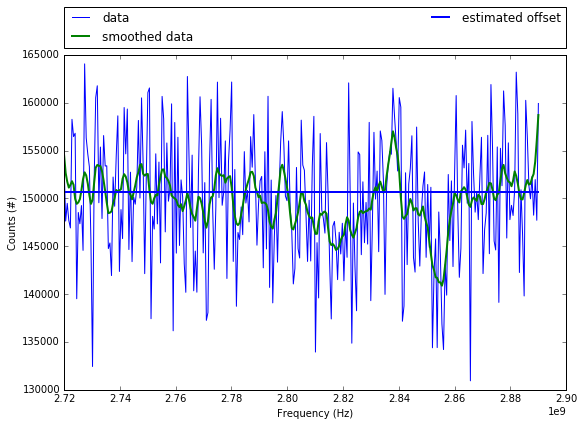

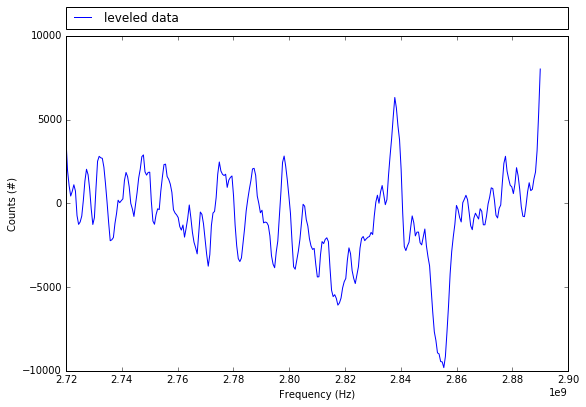

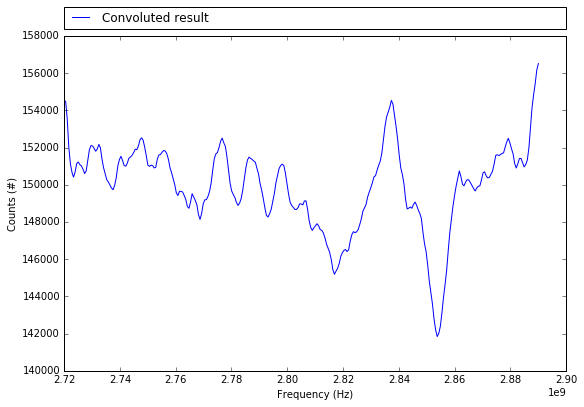

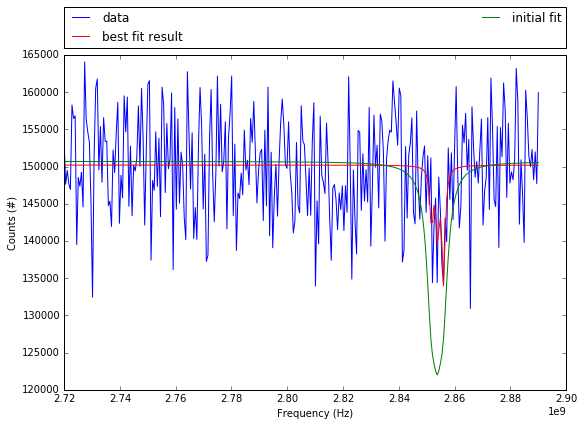

In [22]:
N14_testing()

offset: 100357.457621


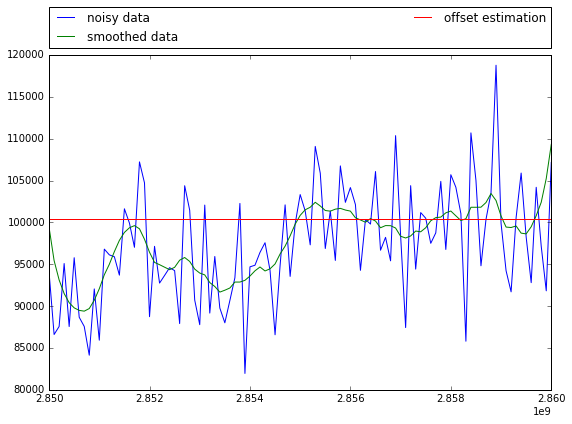

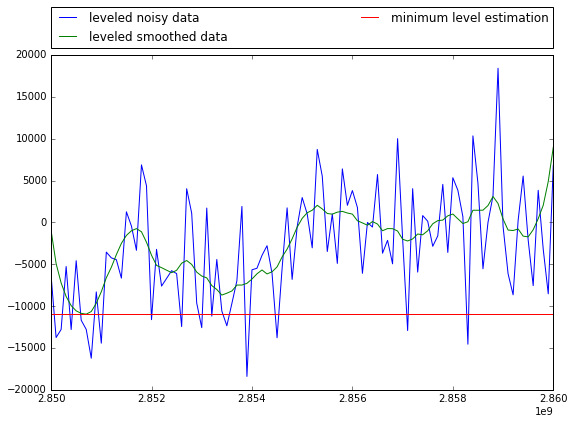

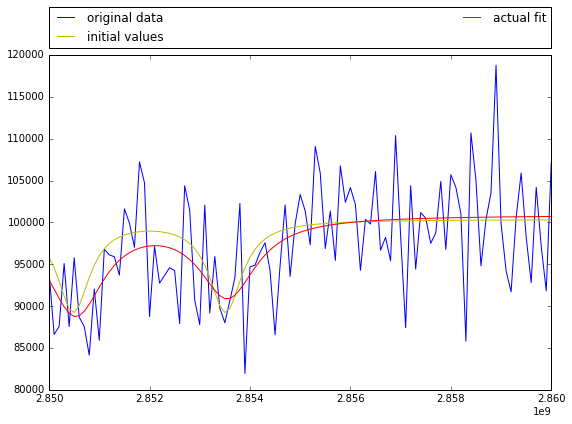

In [23]:
N15_testing()

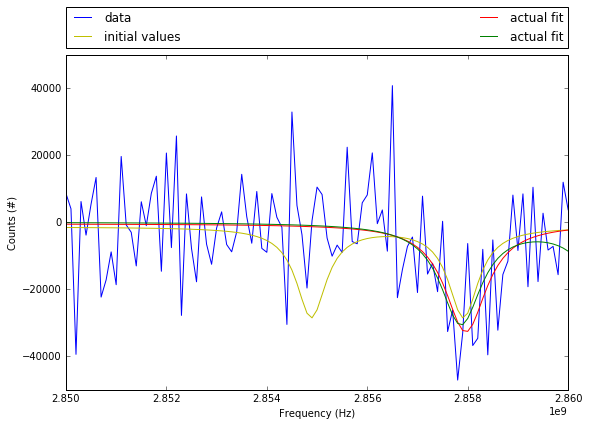

In [24]:
N15_testing2()

mom2 8.68608861822
std:  1.39724384606
[[Model]]
    ((Model(amplitude_function) * Model(physical_gauss)) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 39
    # data points      = 50
    # variables        = 4
    chi-square         = 310203088.078
    reduced chi-square = 6743545.393
[[Variables]]
    fwhm:        1.93141137 +/- 0.339718 (17.59%)  == '2.3548200450309493*sigma'
    contrast:    56.9460384 +/- 9.509516 (16.70%)  == '(amplitude/offset)*100'
    amplitude:   8231.89649 +/- 1.05e+03 (12.72%) (init= 9165.42)
    center:      3.02607829 +/- 0.097155 (3.21%) (init= 2.959184)
    sigma:       0.82019489 +/- 0.144265 (17.59%) (init= 1.397244)
    offset:      14455.6087 +/- 817.5899 (5.66%) (init= 13559.41)
[[Correlations]] (unreported correlations are <  0.100)
    C(sigma, offset)             = -0.734 
    C(amplitude, offset)         = -0.591 
    C(amplitude, sigma)          =  0.116 



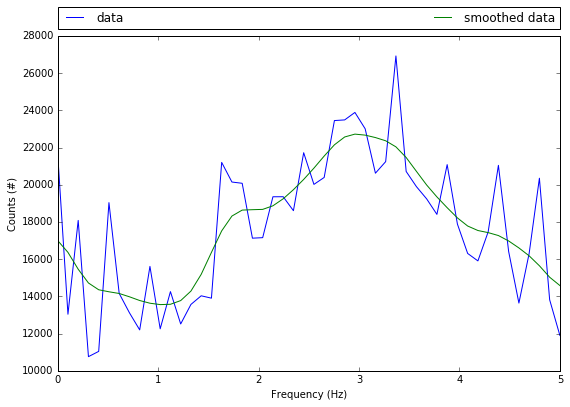

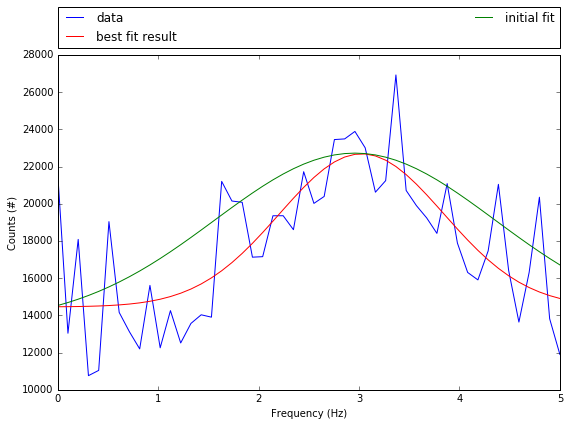

In [25]:
gaussianpeak_testing()

[[Model]]
    ((Model(amplitude_function) * Model(physical_gauss)) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 152
    # data points      = 11
    # variables        = 4
    chi-square         = 50701578.756
    reduced chi-square = 7243082.679
[[Variables]]
    fwhm:        2.37988276 +/- 57.46811 (2414.75%)  == '2.3548200450309493*sigma'
    contrast:    1108.97677 +/- 2.06e+05 (18552.74%)  == '(amplitude/offset)*100'
    amplitude:   1.0424e+05 +/- 1.93e+07 (18549.01%) (init= 2676.16)
    center:     -2.52522211 +/- 135.6660 (5372.44%) (init= 0)
    sigma:       1.01064315 +/- 24.40446 (2414.75%) (init= 1.639352)
    offset:      9399.75458 +/- 1.02e+03 (10.80%) (init= 8782.158)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, center)         = -1.000 
    C(center, sigma)             = -0.999 
    C(amplitude, sigma)          =  0.998 
    C(sigma, offset)             = -0.367 
    C(center, offset)            =  0.355 
    C(ampl

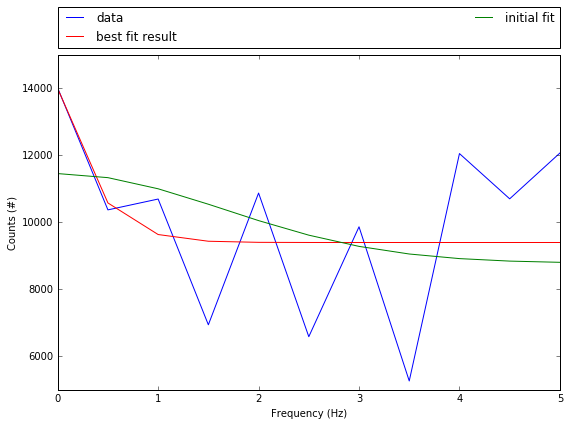

In [26]:
gaussiandip_testing2()

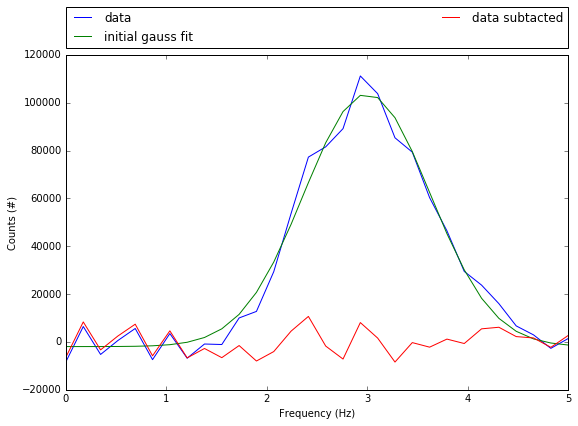

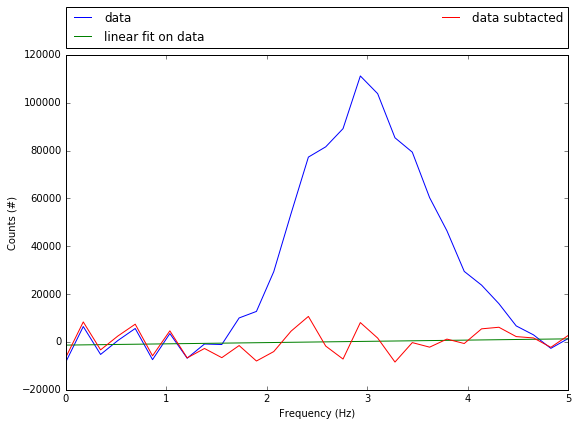

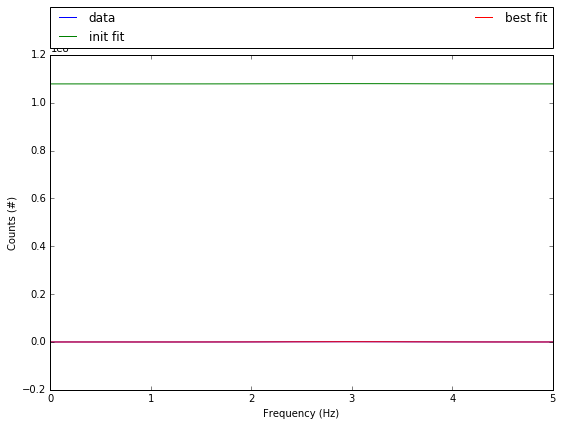

In [27]:
gaussianlinearoffset_testing()

[[Model]]
    (((Model(amplitude_function) * Model(physical_gauss)) + Model(constant_function)) + Model(slope_function))
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 30
    # variables        = 5
    chi-square         = 859862967.492
    reduced chi-square = 34394518.700
[[Variables]]
    fwhm:        2.98928964 +/- 98.18027 (3284.40%)  == '2.3548200450309493*sigma'
    contrast:    0.75933528 +/- 9.530306 (1255.09%)  == '(amplitude/offset)*100'
    amplitude:   1.8883e+05 +/- 2.37e+06 (1255.08%) (init= 187630.7)
    center:      7.51383089 +/- 14.20018 (188.99%) (init= 7.506547)
    sigma:       1.26943443 +/- 3.120852 (245.85%) (init= 1.267817)
    offset:      2.4868e+07 +/- nan      (nan%) (init=-2225.704)
    slope:      -2.4871e+07 +/- nan      (nan%) (init=-174.1699)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, center)         =  0.998 
    C(center, sigma)             =  0.997 
    C(amplitude, sigma)          =  0.991 



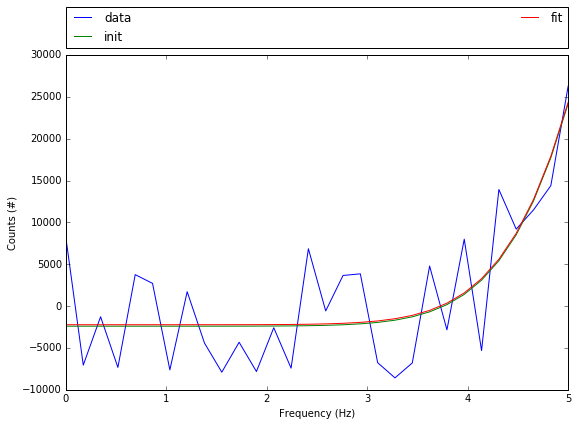

In [28]:
gaussianlinearoffset_testing2()

[[Model]]
    (((Model(amplitude_function, prefix='g0_') * Model(physical_gauss, prefix='g0_')) + Model(constant_function)) + (Model(amplitude_function, prefix='g1_') * Model(physical_gauss, prefix='g1_')))
[[Fit Statistics]]
    # function evals   = 130
    # data points      = 200
    # variables        = 7
    chi-square         = 88576948737.954
    reduced chi-square = 458947920.922
[[Variables]]
    g0_fwhm:        87144.7404 +/- 6.88e+03 (7.90%)  == '2.3548200450309493*g0_sigma'
    g0_contrast:    55221.7804 +/- 3.27e+05 (591.33%)  == '(g0_amplitude/offset)*100'
    g1_fwhm:        36977.7510 +/- 1.94e+04 (52.37%)  == '2.3548200450309493*g1_sigma'
    g1_contrast:    10014.5111 +/- 5.76e+04 (575.39%)  == '(g1_amplitude/offset)*100'
    g0_amplitude:   1.9335e+05 +/- 8.44e+03 (4.36%) (init= 193120)
    g0_center:      1.7139e+05 +/- 4.21e+03 (2.46%) (init= 166331.7)
    g0_sigma:       37006.9639 +/- 2.92e+03 (7.90%) (init= 23798.72)
    offset:         350.142107 +/- 2.06e+03 (

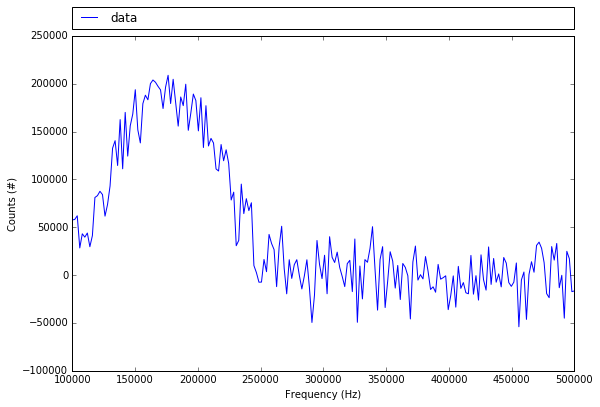

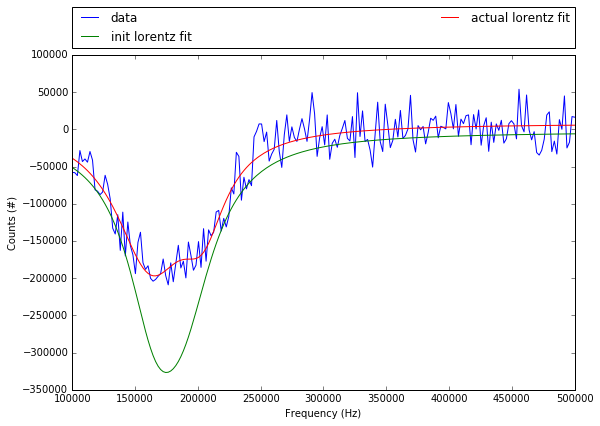

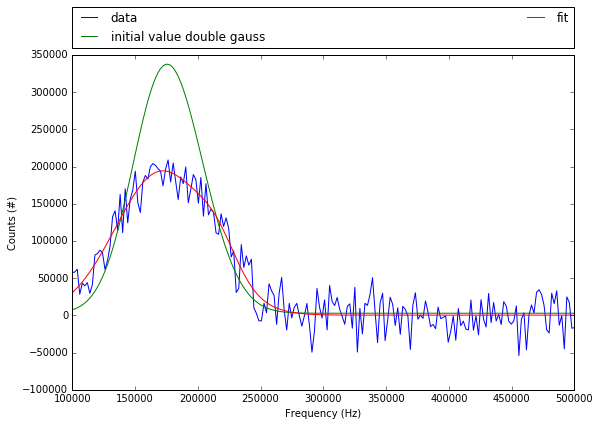

In [29]:
two_gaussian_peak_testing()

In [30]:
two_gaussian_peak_testing2()

Traceback (most recent call last):
  File "/home/jan/qo/qudi/logic/jupyterkernel/qzmqkernel.py", line 795, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-18547487ed06>", line 1, in <module>
    two_gaussian_peak_testing2()
  File "<ipython-input-11-3f7226333c1a>", line 35, in two_gaussian_peak_testing2
    estimator=fitlogic.estimate_gaussiandouble_peak)
  File "/home/jan/qo/qudi/logic/fitmethods/gaussianlikemethods.py", line 580, in make_gaussiandouble_fit
    'unit': units[0]}
TypeError: 'NoneType' object is not subscriptable


In [31]:
two_gaussian_dip_testing2()

Traceback (most recent call last):
  File "/home/jan/qo/qudi/logic/jupyterkernel/qzmqkernel.py", line 795, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-b8b03bfe71aa>", line 1, in <module>
    two_gaussian_dip_testing2()
  File "<ipython-input-12-f224307f1a3c>", line 37, in two_gaussian_dip_testing2
    estimator=fitlogic.estimate_gaussiandouble_dip)
  File "/home/jan/qo/qudi/logic/fitmethods/gaussianlikemethods.py", line 580, in make_gaussiandouble_fit
    'unit': units[0]}
TypeError: 'NoneType' object is not subscriptable


Parameters of the model ['amplitude', 'center', 'sigma', 'offset']
offset 9.10355483015
amplitude -11.6512414232
data_min -2.54768659308
sigma 27.5960298758
[[Model]]
    ((Model(amplitude_function) * Model(physical_lorentzian)) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 38
    # data points      = 101
    # variables        = 4
    chi-square         = 2998.538
    reduced chi-square = 30.913
[[Variables]]
    fwhm:        9.84089914 +/- 3.618912 (36.77%)  == '2*sigma'
    contrast:   -184.646598 +/- 46.07201 (24.95%)  == '(amplitude/offset)*100'
    amplitude:  -16.6392321 +/- 4.001247 (24.05%) (init=-11.65124)
    center:      919.823251 +/- 1.182394 (0.13%) (init= 918)
    sigma:       4.92044957 +/- 1.809456 (36.77%) (init= 27.59603)
    offset:      9.01139378 +/- 0.646709 (7.18%) (init= 9.103555)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, sigma)          =  0.645 
    C(sigma, offset)             =  0.382 



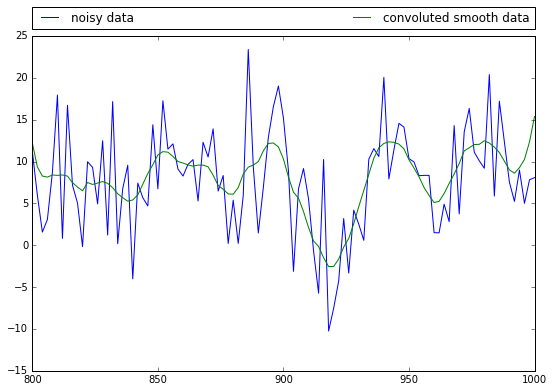

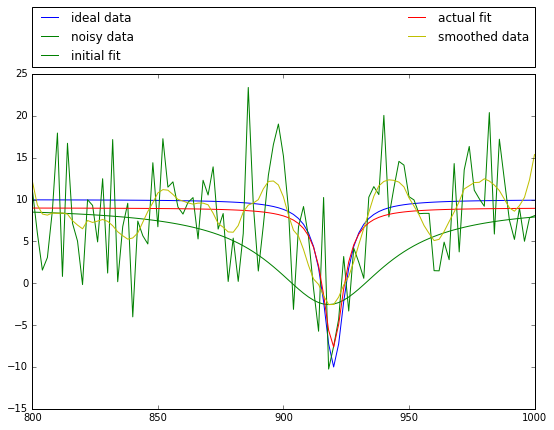

In [32]:
lorentziandip_testing()

Parameters of the model ['amplitude', 'center', 'sigma', 'offset']
<bound method estimate_lorentzian_dip of <logic.fit_logic.FitLogic object at 0x7f691a1d6558>>
[[Model]]
    ((Model(amplitude_function) * Model(physical_lorentzian)) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 13
    # data points      = 101
    # variables        = 4
    chi-square         = 838.954
    reduced chi-square = 8.649
[[Variables]]
    fwhm:        3822.07818 +/- 3.62e-08 (0.00%)  == '2*sigma'
    contrast:   -40.4749591 +/- 15.65890 (38.69%)  == '(amplitude/offset)*100'
    amplitude:  -7.61316016 +/- 2.954953 (38.81%) (init=-7.613091)
    center:      918.000034 +/- 1.679123 (0.18%) (init= 918)
    sigma:       1911.03909 +/- 5.43e-09 (0.00%) (init= 1)
    offset:      18.8095561 +/- 0.303490 (1.61%) (init= 18.80956)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, sigma)          =  0.257 
    C(sigma, offset)             =  0.212 

OrderedDict([('Posit

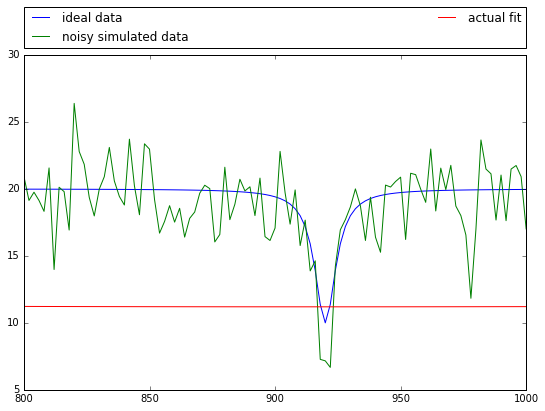

In [33]:
lorentziandip_testing2()

Parameters of the model ['amplitude', 'center', 'sigma', 'offset']


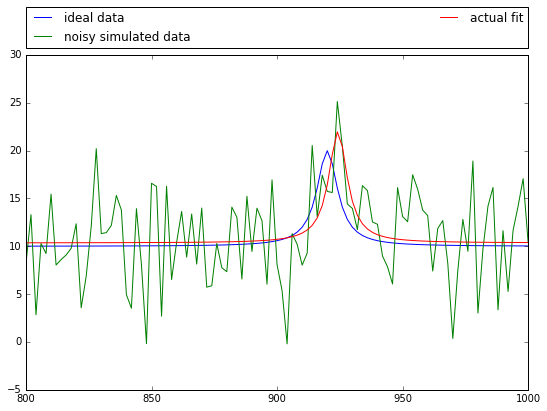

In [34]:
lorentzianpeak_testing2()

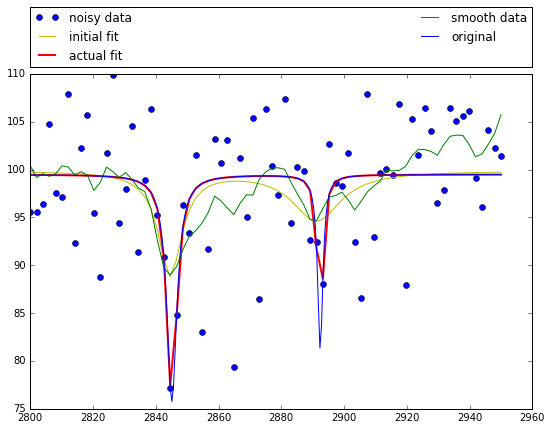

In [35]:
double_lorentzdip_testing()

[[Model]]
    (((Model(amplitude_function, prefix='l0_') * Model(physical_lorentzian, prefix='l0_')) + Model(constant_function)) + (Model(amplitude_function, prefix='l1_') * Model(physical_lorentzian, prefix='l1_')))
[[Fit Statistics]]
    # function evals   = 375
    # data points      = 75
    # variables        = 7
    chi-square         = 2132.873
    reduced chi-square = 31.366
[[Variables]]
    l0_fwhm:        2.02702716 +/- 6.080055 (299.95%)  == '2*l0_sigma'
    l0_contrast:   -23.5571930 +/- 43.90693 (186.38%)  == '(l0_amplitude/offset)*100'
    l1_fwhm:        2.57854468 +/- 3.721756 (144.34%)  == '2*l1_sigma'
    l1_contrast:   -17.9198292 +/- 21.91339 (122.29%)  == '(l1_amplitude/offset)*100'
    l0_amplitude:  -23.8192762 +/- 44.34811 (186.19%) (init=-5.059629)
    l0_center:      2853.51042 +/- 0.526902 (0.02%) (init= 2852.703)
    l0_sigma:       1.01351358 +/- 3.040027 (299.95%) (init= 3.209609)
    offset:         101.112540 +/- 0.759054 (0.75%) (init= 99.99043)
    l1

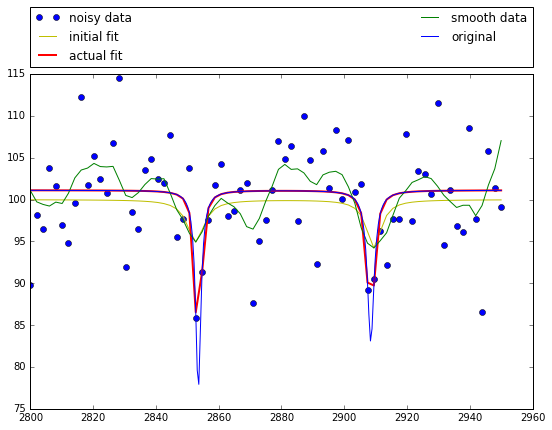

In [36]:
double_lorentzdip_testing2()

In [37]:
double_lorentzian_fixedsplitting_testing()

Traceback (most recent call last):
  File "/home/jan/qo/qudi/logic/jupyterkernel/qzmqkernel.py", line 795, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-37-3f98f2df8972>", line 1, in <module>
    double_lorentzian_fixedsplitting_testing()
  File "<ipython-input-17-4a1cff830865>", line 22, in double_lorentzian_fixedsplitting_testing
    data_noisy = (mod.eval(x=x,params=p) + 2*np.random.normal(size=x.shape))
  File "/usr/lib/python3/dist-packages/lmfit/model.py", line 607, in eval
    return self.op(self.left.eval(params=params, **kwargs),
  File "/usr/lib/python3/dist-packages/lmfit/model.py", line 607, in eval
    return self.op(self.left.eval(params=params, **kwargs),
  File "/usr/lib/python3/dist-packages/lmfit/model.py", line 607, in eval
    return self.op(self.left.eval(params=params, **kwargs),
  File "/usr/lib/python3/dist-packages/lmfit/model.py", line 372, in eval
    result = self.func(**self.make_funcargs(params, kwargs))
TypeError

In [38]:
double_lorentzpeak_testing2()

Traceback (most recent call last):
  File "/home/jan/qo/qudi/logic/jupyterkernel/qzmqkernel.py", line 795, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-38-ecaeea535c90>", line 1, in <module>
    double_lorentzpeak_testing2()
  File "<ipython-input-18-5282405aae10>", line 28, in double_lorentzpeak_testing2
    estimator=fitlogic.estimate_lorentzian_peak)
  File "/home/jan/qo/qudi/logic/fitmethods/lorentzianlikemethods.py", line 441, in make_lorentziandouble_fit
    error, params = estimator(x_axis, data, params)
  File "/home/jan/qo/qudi/logic/fitmethods/lorentzianlikemethods.py", line 406, in estimate_lorentzian_peak
    params_dip)
  File "/home/jan/qo/qudi/logic/fitmethods/lorentzianlikemethods.py", line 374, in estimate_lorentzian_dip
    params['amplitude'].set(value=amplitude, max=-1e-12)
KeyError: 'amplitude'


Parameters of the model ['amplitude', 'frequency', 'phase', 'offset']  with the independet variable x
2.96
0.0986666666666
offset 3.94783020441


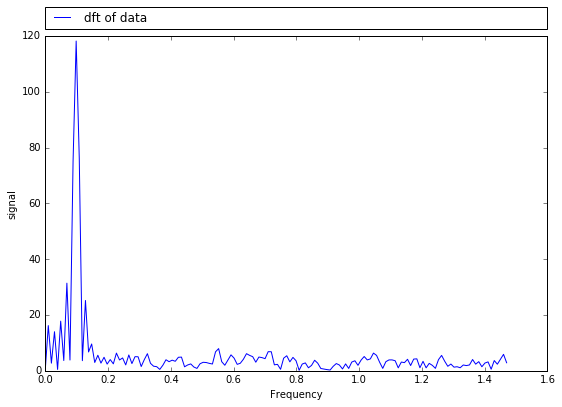

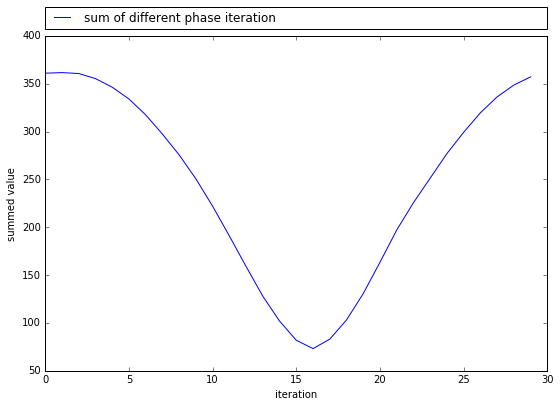

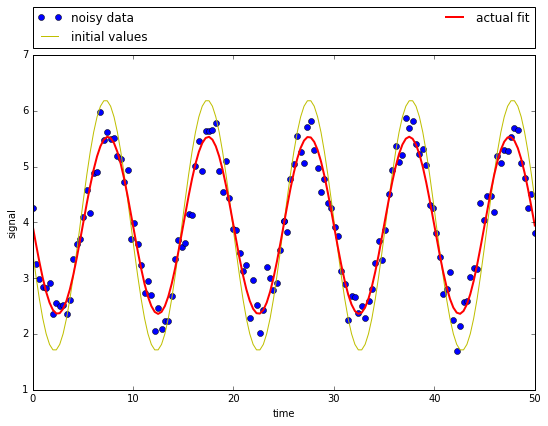

In [39]:
sine_testing()

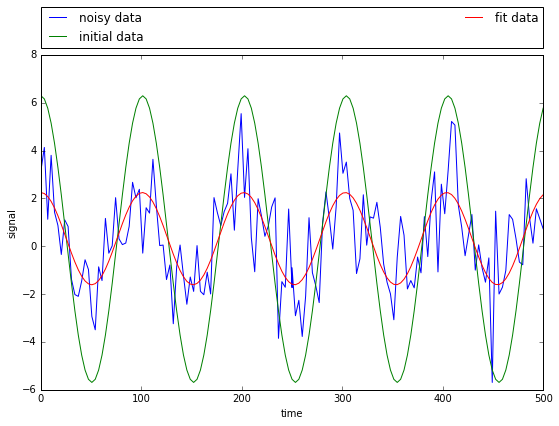

In [40]:
sine_testing2()